# Indexing

This notebook is all about the common task of selecting subsets of data.

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
sns.set(style='ticks', context='talk')

For this section we'll work with some flights data from the US Bureau of Transportation and Statistics.

In [1]:
flights = pd.read_csv("data/ny-flights.csv.gz",
                      parse_dates=["fl_date", "arr", "dep"])

flights.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
0,2014-01-01,AA,19805,N338AA,1,JFK,LAX,914.0,14.0,1238.0,13.0,0.0,2014-01-01 12:38:00,2014-01-01 09:14:00
1,2014-01-01,AA,19805,N335AA,3,JFK,LAX,1157.0,-3.0,1523.0,13.0,0.0,2014-01-01 15:23:00,2014-01-01 11:57:00
2,2014-01-01,AA,19805,N327AA,21,JFK,LAX,1902.0,2.0,2224.0,9.0,0.0,2014-01-01 22:24:00,2014-01-01 19:02:00
3,2014-01-01,AA,19805,N3EHAA,29,LGA,PBI,722.0,-8.0,1014.0,-26.0,0.0,2014-01-01 10:14:00,2014-01-01 07:22:00
4,2014-01-01,AA,19805,N319AA,117,JFK,LAX,1347.0,2.0,1706.0,1.0,0.0,2014-01-01 17:06:00,2014-01-01 13:47:00


`read_csv` returned a `DataFrame`, which is similar in kind to a spreadsheet or database table. It's made up of a few components:

![](dataframe.png)

In [2]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20817 entries, 0 to 20816
Data columns (total 14 columns):
fl_date           20817 non-null datetime64[ns]
unique_carrier    20817 non-null object
airline_id        20817 non-null int64
tail_num          20512 non-null object
fl_num            20817 non-null int64
origin            20817 non-null object
dest              20817 non-null object
dep_time          18462 non-null float64
dep_delay         18462 non-null float64
arr_time          18412 non-null float64
arr_delay         18383 non-null float64
cancelled         20817 non-null float64
arr               18412 non-null datetime64[ns]
dep               18462 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(5), int64(2), object(4)
memory usage: 2.2+ MB


`flights` includes all the flights from New York airports in January 2014.
Each record has information about a single flight including the carrier, tail number, origin, destination, and delays.

To get a bit of intuition about the data we're working with, let's to a brief bit of exploratory analysis. This type of short method chain is pretty common for pandas code.

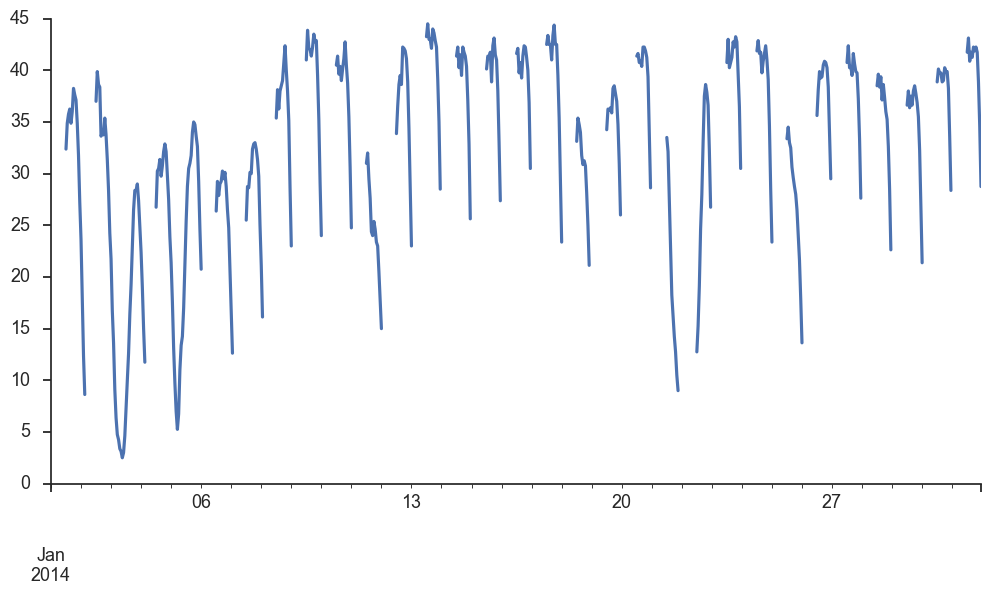

In [40]:
(flights['dep']
    .value_counts()
    .resample('H')
    .sum()
    .rolling(8).mean()
    .plot(figsize=(12, 6)))
sns.despine()
plt.show()

We can plot the count of flights per carrier:

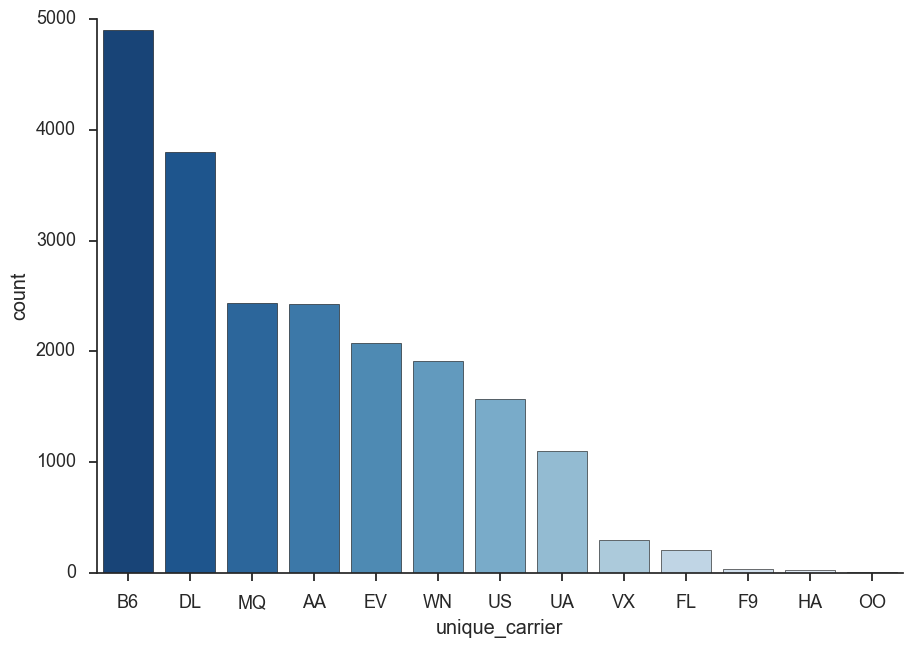

In [43]:
sns.countplot(
    flights['unique_carrier'],
    order=flights['unique_carrier'].value_counts().index,
    palette='Blues_r'
)
sns.despine()

And the joint distribution of departure and arrival delays:

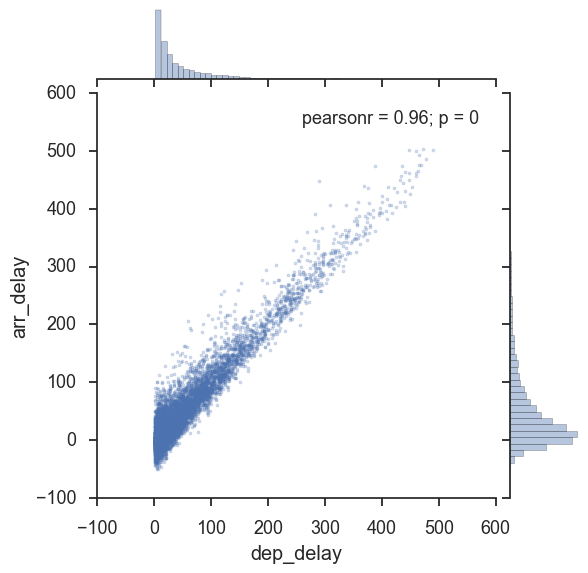

In [44]:
sns.jointplot('dep_delay', 'arr_delay',
              flights[(flights['dep_delay'] > 1) &
                      (flights['dep_delay'] < 500)],
              alpha=.25, marker='.');

We'll explore some of those methods and visualization techniques later.
For now we'll turn to the more fundamental operation of indexing.

## Goals of Indexing

By indexing, we mean selecting subsets of your data.
It's a good starting point, because it comes up in so many other places;
It's a terrible starting point because it's somewhat complicated, and somewhat boring.


There are many ways you might want to specify which subset you want to select:

- Like lists, you can index by integer location.
- Like dictionaries, you can index by label.
- Like NumPy arrays, you can index by boolean masks.
- You can index with scalar, `slice`s, or arrays
- Any of these should work on the index (row labels), or columns of a DataFrame, or both
- And any of these should work on Hierarchical indexes.

Let's get a DataFrame with a labeled index by selecting the
first flight for each carrier. We'll talk about `groupby` later.

In [45]:
# first
first = flights.groupby("unique_carrier").first()
first.head()

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
B6,2014-01-01,20409,N318JB,115,SYR,JFK,720.00,90.00,808.00,55.00,0.00,2014-01-01 08:08:00,2014-01-01 07:20:00
DL,2014-01-01,19790,N930DL,61,LGA,ATL,"1,810.00",10.00,"2,054.00",10.00,0.00,2014-01-01 20:54:00,2014-01-01 18:10:00
EV,2014-01-01,20366,N14977,3259,HPN,ORD,731.00,-5.00,940.00,31.00,0.00,2014-01-01 09:40:00,2014-01-01 07:31:00
F9,2014-01-01,20436,N209FR,507,LGA,DEN,"1,804.00",35.00,"2,047.00",47.00,0.00,2014-01-01 20:47:00,2014-01-01 18:04:00


## The Basic Rules

The one cell to take away from our session:

1. Use `__getitem__` (square brackets) to select columns of a `DataFrame`

    ```python
    >>> df[['a', 'b', 'c']]
    ```

2. Use `.loc` for label-based indexing (rows and columns)

    ```python
    >>> df.loc[row_labels, column_labels]
    ```

3. Use `.iloc` for position-based indexing (rows and columns)

    ```python
    >>> df.iloc[row_positions, column_positions]
    ```

The arguments to `.loc` and `.iloc` are `.loc[row_indexer, column_indexer]`. An indexer can be one of

- A scalar or array of row labels
- A `slice` object
- A boolean mask

The column indexer is optional.
We'll walk through all the combinations below.

### 1. Selecting Columns with `__getitem__`

Let's select the two delay columns. Since we're *only* filtering the columns (not rows), we can use dictionary-like `[]` to do the slicing:

In [12]:
first[['dep_delay', 'arr_delay']]

,dep_delay,arr_delay
unique_carrier,,
AA,14.00,13.00
B6,90.00,55.00
DL,10.00,10.00
EV,-5.00,31.00
F9,35.00,47.00
...,...,...
OO,49.00,47.00
UA,0.00,8.00
US,-6.00,-39.00


One potential source of confusion: python uses `[]` for two purposes

1. building a list
2. slicing with `__getitem__`

In [13]:
# 1. build the list cols
cols = ['dep_delay', 'arr_delay']
# 2. slice, with cols as the argument to `__getitem__`
first[cols]

,dep_delay,arr_delay
unique_carrier,,
AA,14.00,13.00
B6,90.00,55.00
DL,10.00,10.00
EV,-5.00,31.00
F9,35.00,47.00
...,...,...
OO,49.00,47.00
UA,0.00,8.00
US,-6.00,-39.00


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Select the two location columns, 'origin' and 'dest', from `first`.

In [19]:
first[['origin', 'dest']]

,origin,dest
unique_carrier,,
AA,JFK,LAX
B6,SYR,JFK
DL,LGA,ATL
EV,HPN,ORD
F9,LGA,DEN
...,...,...
OO,SYR,ORD
UA,LGA,ORD
US,JFK,PHX


In [ ]:
# TODO: Solution
%load solutions

As a convenience, pandas attaches the column names to your `DataFrame` when they're valid [python identifiers](https://docs.python.org/3/reference/lexical_analysis.html), and don't override one of the ([many](http://pandas.pydata.org/pandas-docs/stable/api.html#dataframe)) methods on `DataFrame`:

In [51]:
flights.tail_num.value_counts()
# Same as flights['tail_num'].value_counts()

N292JB    76
N258JB    69
N306JB    68
N523MQ    59
N324JB    58
          ..
N396SW     1
N651SW     1
N250WN     1
N699DL     1
N350AA     1
Name: tail_num, dtype: int64

This is nice when working interactively.
However, thanks to the risk of pandas adding methods in the future that could clash with your column names, it's recommended to stick with `__getitem__` for production code:

In [55]:
x = pd.DataFrame({"mean": [1, 2, 3]})
x

,mean
0,1
1,2
2,3


In [56]:
# returns the method, not the column
x.mean

<bound method DataFrame.mean of    mean
0     1
1     2
2     3>

Finally, you can't *assign* with `.`, while you can with `__setitem__` (square brackets on the left-hand side):

In [58]:
x.wrong = ['a', 'b', 'c']
x['right'] = ['a', 'b', 'c']
x

,mean,right
0,1,a
1,2,b
2,3,c


In [59]:
x.wrong

['a', 'b', 'c']

`DataFrame`s, like most python objects, allow you to attach arbitrary attributes to any instance.
This means `x.wrong = ...` attaches the thing on the right-hand side to the object on the left.

## Label-Based Indexing with `.loc`

You can slice rows by label (and optionally the columns too) with `.loc`.
Let's select the rows for the carriers 'AA', 'DL', 'US', and 'WN'.

In [24]:
carriers = ['AA', 'DL', 'US', 'WN']
# Select those carriers by label
first.loc[carriers]  # no column indexer

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
DL,2014-01-01,19790,N930DL,61,LGA,ATL,"1,810.00",10.00,"2,054.00",10.00,0.00,2014-01-01 20:54:00,2014-01-01 18:10:00
US,2014-01-01,20355,N546UW,629,JFK,PHX,"1,624.00",-6.00,"1,932.00",-39.00,0.00,2014-01-01 19:32:00,2014-01-01 16:24:00
WN,2014-01-01,19393,N625SW,613,ALB,BWI,"1,502.00",17.00,"1,615.00",15.00,0.00,2014-01-01 16:15:00,2014-01-01 15:02:00


Indexing both rows and columns:

In [27]:
# select just `carriers` and origin, dest, and dep_delay
first.loc[carriers, ['origin', 'dest', 'dep_delay']]

,origin,dest,dep_delay
unique_carrier,,,
AA,JFK,LAX,14.00
DL,LGA,ATL,10.00
US,JFK,PHX,-6.00
WN,ALB,BWI,17.00


Pandas will *reduce dimensionality* when possible, so slicing with a scalar
will return a Series (usually; the exception being duplicates in the index or columns)

In [26]:
# select just tail_num for those `carriers`
first.loc[carriers, 'tail_num']

unique_carrier
AA    N338AA
DL    N930DL
US    N546UW
WN    N625SW
Name: tail_num, dtype: object

## `slice` objects

`slice`s make the most sense when your index is sorted.

In [28]:
# slice from AA to DL
first.loc['AA':'DL']

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
B6,2014-01-01,20409,N318JB,115,SYR,JFK,720.00,90.00,808.00,55.00,0.00,2014-01-01 08:08:00,2014-01-01 07:20:00
DL,2014-01-01,19790,N930DL,61,LGA,ATL,"1,810.00",10.00,"2,054.00",10.00,0.00,2014-01-01 20:54:00,2014-01-01 18:10:00


Notice that the slice is inclusive on *both* sides *when using `.loc`* (`.iloc` follows the usual python symantics of closed on the left, open on the right).

## Boolean Indexing

This is esstentially a SQL `WHERE` clause. For example, let's select flights from the 5 most common origins:

In [29]:
# Get the counts for `flights.origin`
origin_counts = flights.origin.value_counts()
origin_counts

LGA    8530
JFK    7878
BUF    1348
ROC     676
HPN     615
       ... 
SYR     554
ISP     398
ELM     105
SWF      62
ART      58
Name: origin, dtype: int64

`Series.value_counts` will return a Series where the index is the set of unique values, and the data is the number of occurrances of that value. It's sorted in descending order, so we can get the 5 most common labels with:

In [128]:
# Get a boolean mask for whether `counts` is in the top 5.
top5 = origin_counts.index[:5]
top5

Index(['LGA', 'JFK', 'BUF', 'ROC', 'HPN'], dtype='object')

We'll use a *boolean mask* to filter the rows.

In [133]:
mask = flights.origin.isin(top5)
mask

0        True
1        True
2        True
3        True
4        True
         ... 
20812    True
20813    True
20814    True
20815    True
20816    True
Name: origin, dtype: bool

In [134]:
flights.loc[mask, ['origin', 'dest']]

,origin,dest
0,JFK,LAX
1,JFK,LAX
2,JFK,LAX
3,LGA,PBI
4,JFK,LAX
...,...,...
20812,ROC,ORD
20813,LGA,CLE
20814,LGA,IAH
20815,LGA,IAH


You can pass boolean masks to regular `[]`, `.loc`, or `.iloc`, and they all filter the rows.

Boolean indexers are useful because so many operations can produce an array of booleans.

- null checks (`.isnull`, `.notnull`)
- container checks (`.isin`)
- boolean aggregations (`.any`, `.all`)
- comparisions (`.gt`, `.lt`, etc.)

In [66]:
# Select rows where `dep` is null

flights.loc[flights.dep.isnull()]

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
321,2014-01-01,AA,19805,N3EAAA,359,LGA,ORD,nan,nan,nan,nan,1.00,NaT,NaT
338,2014-01-01,AA,19805,N542AA,371,LGA,ORD,nan,nan,nan,nan,1.00,NaT,NaT
2337,2014-01-01,B6,20409,N913JB,1103,JFK,SJU,nan,nan,nan,nan,1.00,NaT,NaT
2373,2014-01-01,B6,20409,N193JB,518,JFK,BOS,nan,nan,nan,nan,1.00,NaT,NaT
4224,2014-01-01,EV,20366,N17159,4130,SYR,CLE,nan,nan,nan,nan,1.00,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466787,2014-01-31,DL,19790,N908DA,2129,ROC,ATL,nan,nan,nan,nan,1.00,NaT,NaT
466827,2014-01-31,DL,19790,N965DL,2165,JFK,TPA,nan,nan,nan,nan,1.00,NaT,NaT
468067,2014-01-31,MQ,20398,N672MQ,3075,SYR,ORD,nan,nan,nan,nan,1.00,NaT,NaT
468392,2014-01-31,MQ,20398,N507MQ,3281,LGA,CMH,nan,nan,nan,nan,1.00,NaT,NaT


In [31]:
first.head()

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
B6,2014-01-01,20409,N318JB,115,SYR,JFK,720.00,90.00,808.00,55.00,0.00,2014-01-01 08:08:00,2014-01-01 07:20:00
DL,2014-01-01,19790,N930DL,61,LGA,ATL,"1,810.00",10.00,"2,054.00",10.00,0.00,2014-01-01 20:54:00,2014-01-01 18:10:00
EV,2014-01-01,20366,N14977,3259,HPN,ORD,731.00,-5.00,940.00,31.00,0.00,2014-01-01 09:40:00,2014-01-01 07:31:00
F9,2014-01-01,20436,N209FR,507,LGA,DEN,"1,804.00",35.00,"2,047.00",47.00,0.00,2014-01-01 20:47:00,2014-01-01 18:04:00


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Using the `first` DataFrame, select the 2 columns for locations (`origin`, `dest`), the 2 departure time columns (`dep_time`, `dep_delay`), and the 2 arrival columns (`arr_time`, `arr_delay`), for the carriers `AA`, `B6`, and `DL`.

In [35]:
# TODO: solution

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Filter down to rows where the departure **`hour`** is before 6:00 or after 18:00.

- Hint: Use the `flights.dep.dt` namespace. See the attributes [here](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html) or use tab-completion on `flights.dep.dt.<tab>`
- Hint: NumPy and pandas use `|` for elementwise `or`, and `&` for elementwise `and` between two boolean arrays
- Hint: Be careful with [Python's order of operations](https://docs.python.org/3/reference/expressions.html#operator-precedence) between comparison operators (`<`, `>`) and NumPy's logical operators `|` and `&`


In [37]:
%load solutions/indexing_00.py

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
2,2014-01-01,AA,19805,N327AA,21,JFK,LAX,"1,902.00",2.00,"2,224.00",9.00,0.00,2014-01-01 22:24:00,2014-01-01 19:02:00
5,2014-01-01,AA,19805,N323AA,185,JFK,LAX,"2,133.00",-2.00,37.00,-18.00,0.00,2014-01-01 00:37:00,2014-01-01 21:33:00
8,2014-01-01,AA,19805,N3HYAA,235,JFK,SEA,"1,848.00",-2.00,"2,206.00",-14.00,0.00,2014-01-01 22:06:00,2014-01-01 18:48:00
11,2014-01-01,AA,19805,N336AA,181,JFK,LAX,"1,907.00",142.00,"2,223.00",133.00,0.00,2014-01-01 22:23:00,2014-01-01 19:07:00
16,2014-01-01,AA,19805,N3KHAA,301,LGA,ORD,553.00,-7.00,739.00,-6.00,0.00,2014-01-01 07:39:00,2014-01-01 05:53:00


### Position-Based Indexing with `.iloc`

This takes the same basic forms as `.loc`, except you use integers to designate *positions* instead of labels.

In [38]:
first.iloc[[0, 1, 2], [1, 2]]

,airline_id,tail_num
unique_carrier,,
AA,19805,N338AA
B6,20409,N318JB
DL,19790,N930DL


You can use scalars, arrays, boolean masks, or slices.
The one notable difference compared to label-based indexing is with `slice` objects.
Recall that `.loc` included both ends of the slice.
`.loc` uses the usual python behavior of slicing up to, but not including, the end point:

In [139]:
# select the first two rows, and the 3rd, 4th, and 5th columns
first.iloc[:2, 3:6]

,fl_num,origin,dest
unique_carrier,,,
AA,1,JFK,LAX
B6,115,SYR,JFK


In [60]:
first.loc?

<div class="alert alert-success">
  <h1><i class="fa fa-lightbulb-o" aria-hidden="true"></i> Thought Exercise</h1>
</div>

Why does pandas use a property like `.loc[..., ...]`, rather than a method like `.loc(..., ...)`?

- Hint: Where in the language can you use `foo.loc[...]`, but not `foo.loc(...)`?